# Import some Python modules

In [1]:
% matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import requests
import io
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output 

In [3]:
!pip install kora
import kora.install.rdkit
clear_output()

In [4]:
!pip install git+https://github.com/samoturk/mol2vec
clear_output()

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from mol2vec.features import mol2alt_sentence, sentences2vec, mol2sentence, MolSentence, DfVec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg

Get dataset from repository

In [6]:
url = 'https://github.com/GLambard/Molecules_Dataset_Collection/raw/master/originals/HIV.csv'

data = requests.get(url).content
df = pd.read_csv(io.StringIO(data.decode('utf-8')), index_col = 0)
df.reset_index(inplace=True)
df

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0


# Pre-Processing Data

In [7]:
df['activity'].value_counts()

CI    39684
CM     1039
CA      404
Name: activity, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


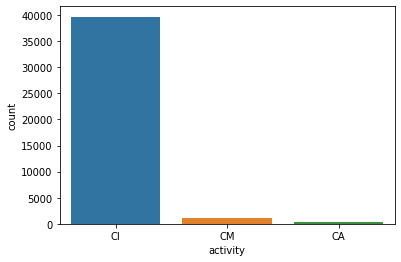

In [8]:
sns.countplot(df['activity'])

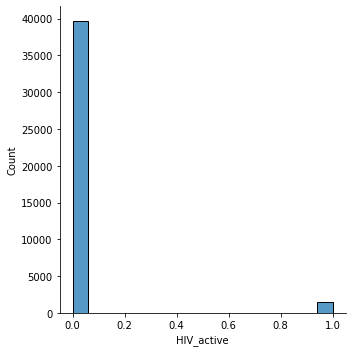

In [9]:
sns.displot(df['HIV_active'])

In [10]:
df['HIV_active'].value_counts()

0    39684
1     1443
Name: HIV_active, dtype: int64

In [11]:
df_smis = df['smiles']
df_smis = df_smis.to_list()
df_smis

['CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2',
 'C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3)CC(c3ccccc3)=[O+]2)[O+]=C(c2ccccc2)C1',
 'CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21',
 'Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1',
 'O=S(=O)(O)CCS(=O)(=O)O',
 'CCOP(=O)(Nc1cccc(Cl)c1)OCC',
 'O=C(O)c1ccccc1O',
 'CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O',
 'O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+](=O)[O-])c([N+](=O)[O-])c1',
 'O=[N+]([O-])c1ccccc1SSc1ccccc1[N+](=O)[O-]',
 'CC(C)(CCC(=O)O)CCC(=O)O',
 'O=C(O)Cc1ccc(SSc2ccc(CC(=O)O)cc2)cc1',
 'O=C(O)c1ccccc1SSc1ccccc1C(=O)O',
 'CCCCCCCCCCCC(=O)Nc1ccc(SSc2ccc(NC(=O)CCCCCCCCCCC)cc2)cc1',
 'Sc1cccc2c(S)cccc12',
 'CCOP(N)(=O)c1ccccc1',
 'NNP(=S)(NN)c1ccccc1',
 'O=P(Nc1ccccc1)(Nc1ccccc1)Nc1ccccc1',
 'O=C1C(O)=C(CCCc2ccc(Oc3ccccc3)cc2)C(=O)c2ccccc21',
 'CC(C)N(C(C)C)P(=O)(OP(=O)(c1ccc([N+](=O)[O-])cc1)N(C(C)C)C(C)C)c1ccc([N+](=O)[O-])cc1',
 'c1ccc2c(c1)Sc1ccccc1S2',
 'CC(C)CCS(=O)(=O)O',
 'Cc1ccccc1NC(=N)Nc1ccccc1C',
 'CCCNP(=S)(NCCC)NCCC',


# Mol2Vec
DOC:
https://mol2vec.readthedocs.io/en/latest/#usage
Notebook:
https://hub-binder.mybinder.ovh/user/samoturk-mol2vec_notebooks-xlro8o42/notebooks/Notebooks/Exploring_Mol2vec_vectors.ipynb


**Generating Molecules**

In [12]:
mol = [Chem.MolFromSmiles(x) for x in df_smis]

RDKit WARNING: [23:55:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:55:30] WARNING: not removing hydrogen atom without neighbors


In [13]:
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.rdchem import PeriodicTable as pt

/usr/local/lib/python3.7/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


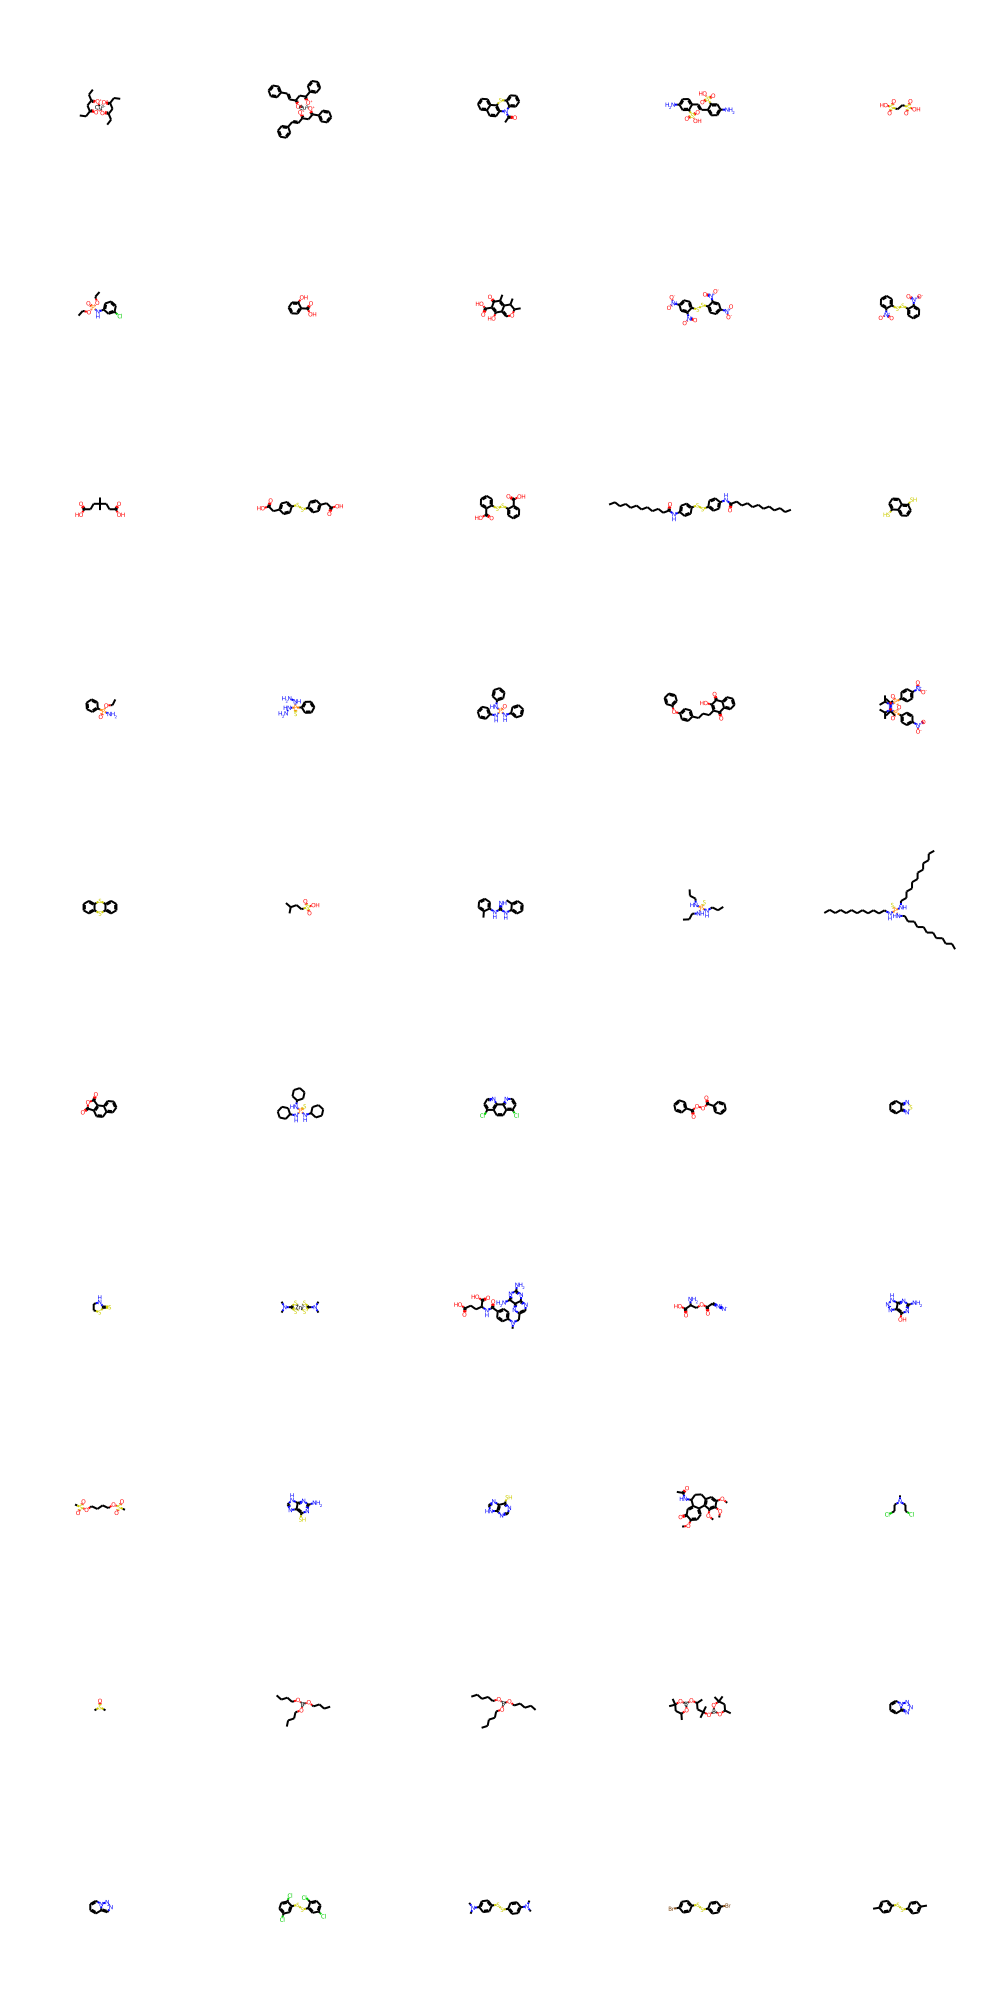

In [14]:
Draw.MolsToGridImage(mol, molsPerRow=5, useSVG=False)

**Encoding substructures of a molecule as words**

In [15]:
sentence = mol2alt_sentence(mol[1], 1)
sentence

['2246703798',
 '980020035',
 '2246703798',
 '980020035',
 '3217380708',
 '3011598321',
 '3218693969',
 '951226070',
 '3218693969',
 '98513984',
 '3218693969',
 '98513984',
 '3218693969',
 '98513984',
 '3218693969',
 '951226070',
 '3217380708',
 '2713709787',
 '3189554341',
 '550725541',
 '42119399',
 '579608548',
 '3189554341',
 '550725541',
 '3217380708',
 '2713709787',
 '2246703798',
 '980020035',
 '2246703798',
 '980020035',
 '3217380708',
 '3011598321',
 '3218693969',
 '951226070',
 '3218693969',
 '98513984',
 '3218693969',
 '98513984',
 '3218693969',
 '98513984',
 '3218693969',
 '951226070',
 '2968968094',
 '4142616092',
 '3217380708',
 '1655331964',
 '3217380708',
 '2353112200',
 '3218693969',
 '951226070',
 '3218693969',
 '98513984',
 '3218693969',
 '98513984',
 '3218693969',
 '98513984',
 '3218693969',
 '951226070',
 '3189554341',
 '550725541',
 '3189554341',
 '550725541',
 '3217380708',
 '1655331964',
 '3217380708',
 '2353112200',
 '3218693969',
 '951226070',
 '3218693969',
 

In [16]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('model_300dim.pkl')

In [17]:
len(model.wv.vocab.keys())

21003

In [18]:
vec_identifiers = sentences2vec(sentence, model=model, unseen='UNK')
vec_identifiers

array([[ 1.2513949,  2.334477 , -1.2833012, ..., -3.1253083, -1.1473327,
         1.8111763],
       [ 1.1262554,  2.1010292, -1.1549711, ..., -2.8127775, -1.0325994,
         1.6300586],
       [ 1.2513949,  2.334477 , -1.2833012, ..., -3.1253083, -1.1473327,
         1.8111763],
       ...,
       [ 1.1262554,  2.1010292, -1.1549711, ..., -2.8127775, -1.0325994,
         1.6300586],
       [ 1.2513949,  2.334477 , -1.2833012, ..., -3.1253083, -1.1473327,
         1.8111763],
       [ 1.2513949,  2.334477 , -1.2833012, ..., -3.1253083, -1.1473327,
         1.8111763]], dtype=float32)

In [19]:
df_vec = pd.DataFrame()
df_vec = MolSentence(sentence)
df_vec

MolSentence with 78 words

# Embeddigns Generator - DeepMol

Deep Mol - Test

In [4]:
from typing import Any, Optional
from Datasets.Datasets import Dataset
from gensim.models import word2vec
import os, sys
class Mol2Vec():
    '''Mol2Vec fingerprint implementation from https://doi.org/10.1021/acs.jcim.7b00616
    Inspired by natural language processing techniques, Mol2vec, which is an unsupervised machine learning
    approach to learn vector representations of molecular substructures. Mol2vec learns vector representations
    of molecular substructures that point in similar directions for chemically related substructures.
    Compounds can finally be encoded as vectors by summing the vectors of the individual substructures and,
    for instance, be fed into supervised machine learning approaches to predict compound properties.
    '''

    def __init__(self):
        self.model = word2vec.Word2Vec.load('model_300dim.pkl')
        
    
    def featurize(self, dataset: Dataset, log_every_n=1000):
        molecules = [Chem.MolFromSmiles(x) for x in dataset.mols]
        sentences = [mol2alt_sentence(x, 2) for x in molecules]
        vectors = [DfVec(x) for x in sentences2vec(sentences, self.model, unseen='UNK')]
        dataset.X = np.array([x.vec for x in vectors])
        return dataset
    

In [2]:
from loaders.Loaders import CSVLoader
dataset = CSVLoader(dataset_path='HIV.csv', 
                    mols_field='smiles', 
                    labels_fields='HIV_active')#, shard_size=4000)
dataset = dataset.create_dataset()
dataset.get_shape()

Mols_shape:  41127
Features_shape:  X not defined!
Labels_shape:  (41127,)


In [5]:
dataset = Mol2Vec().featurize(dataset)
dataset.get_shape()

Mols_shape:  41127
Features_shape:  (41127, 300)
Labels_shape:  (41127,)


In [6]:
from splitters.splitters import SingletaskStratifiedSplitter
from models.sklearnModels import SklearnModel
from metrics.Metrics import Metric
from metrics.metricsFunctions import roc_auc_score, precision_score, accuracy_score, confusion_matrix, classification_report, f1_score
from parameterOptimization.HyperparameterOpt import GridHyperparamOpt

from sklearn.ensemble import RandomForestClassifier

In [7]:
#Data Split
splitter = SingletaskStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=dataset, frac_train=0.6, 
                                                                             frac_valid=0.2, frac_test=0.2)

In [8]:
#Scikit-Learn Random Forest
rf = RandomForestClassifier()
model = SklearnModel(model=rf)

In [9]:
#cross validation
model.cross_validate(dataset, Metric(roc_auc_score), folds=3)

Computing Stratified K-fold split
Train Score: 
roc_auc_score: 
 0.9994802494802495
Test Score: 
roc_auc_score: 
 0.5904933276418006
Train Score: 
roc_auc_score: 
 0.997920997920998
Test Score: 
roc_auc_score: 
 0.5968059310968293
Train Score: 
roc_auc_score: 
 1.0
Test Score: 
roc_auc_score: 
 0.6002835602926319


(SklearnModel(model=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                           class_weight=None, criterion='gini',
                                           max_depth=None, max_features='auto',
                                           max_leaf_nodes=None, max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
              model_dir='/tmp/tmpfrra6yo1'),
 1.0,
 0.6002835602926319,
 [0.9994802494802495, 0.997920997920998, 1.0],
 

In [10]:
# model training
model.fit(train_dataset)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
metrics = [Metric(roc_auc_score), Metric(precision_score), Metric(accuracy_score), Metric(confusion_matrix), 
           Metric(classification_report)]
print("#############################")
# evaluate the model
print('Training Dataset: ')
train_score = model.evaluate(train_dataset, metrics)
print("#############################")
print('Validation Dataset: ')
valid_score = model.evaluate(valid_dataset, metrics)
print("#############################")
print('Test Dataset: ')
test_score = model.evaluate(test_dataset, metrics)
print("#############################")

#############################
Training Dataset: 
roc_auc_score: 
 1.0
precision_score: 
 1.0
accuracy_score: 
 1.0
confusion_matrix: 
 [[23810     0]
 [    0   862]]
classification_report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23810
           1       1.00      1.00      1.00       862

    accuracy                           1.00     24672
   macro avg       1.00      1.00      1.00     24672
weighted avg       1.00      1.00      1.00     24672

#############################
Validation Dataset: 
roc_auc_score: 
 0.594432901257683
precision_score: 
 0.7142857142857143
accuracy_score: 
 0.9691147859922179
confusion_matrix: 
 [[7915   22]
 [ 232   55]]
classification_report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      7937
           1       0.71      0.19      0.30       287

    accuracy                           0.97      8224
   macro avg       0.84      0.